In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.datasets import ImageFolder
from PIL import Image
import os
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Epoch [1/50000], Step [0/172], D Loss: 1.4872, G Loss: 0.5469


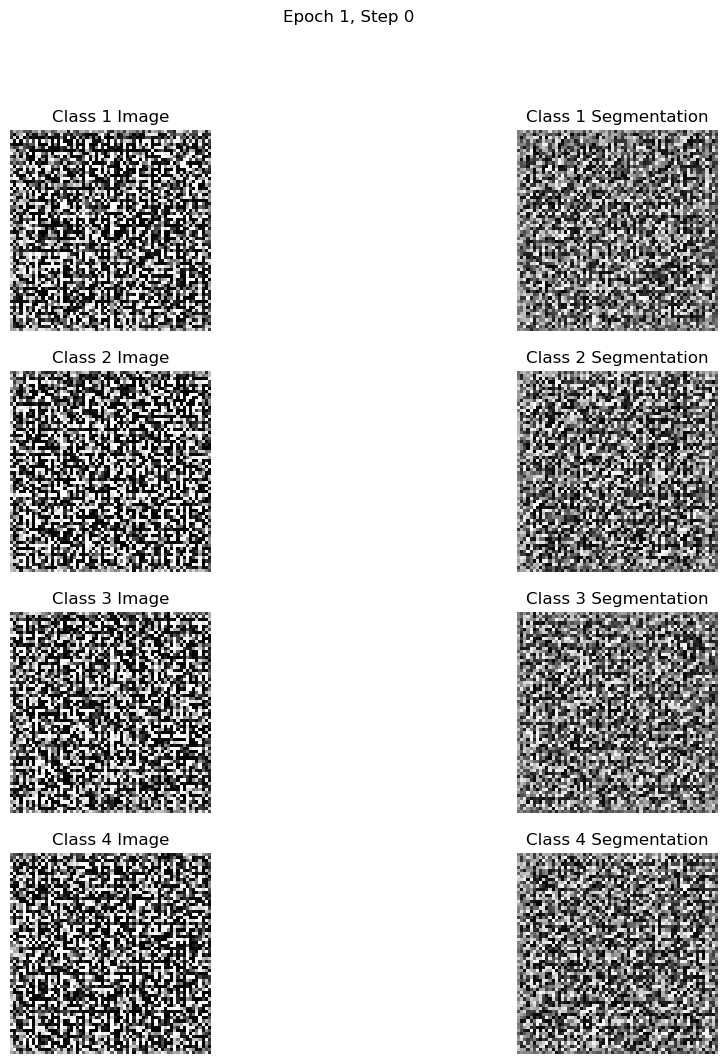

Epoch [101/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931
Epoch [201/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931
Epoch [301/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931
Epoch [401/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931
Epoch [501/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931
Epoch [601/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931
Epoch [701/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931
Epoch [801/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931
Epoch [901/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931
Epoch [1001/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931


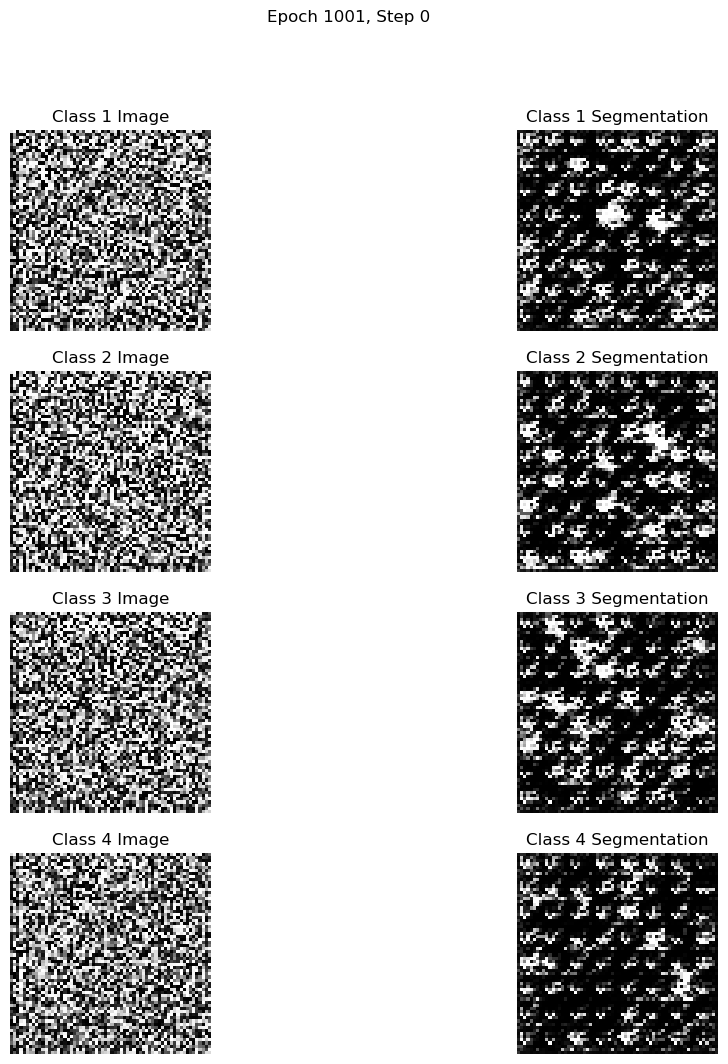

Epoch [1101/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931
Epoch [1201/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931
Epoch [1301/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931
Epoch [1401/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931
Epoch [1501/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931
Epoch [1601/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931
Epoch [1701/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931
Epoch [1801/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931
Epoch [1901/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931
Epoch [2001/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931


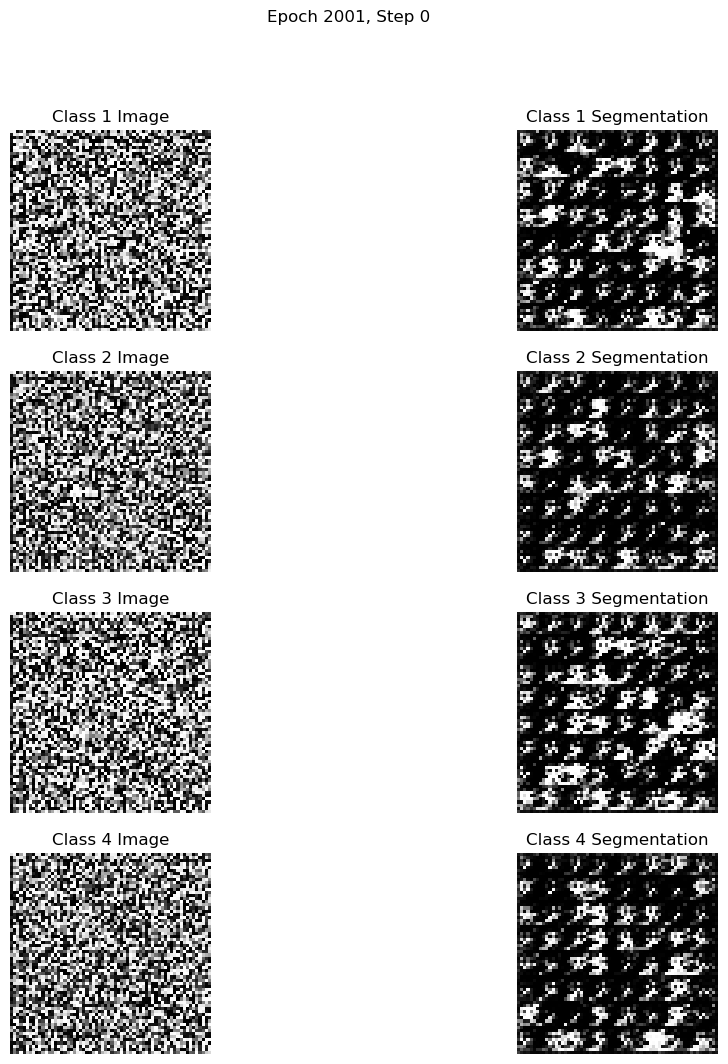

Epoch [2101/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931
Epoch [2201/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931
Epoch [2301/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931
Epoch [2401/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931
Epoch [2501/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931
Epoch [2601/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931
Epoch [2701/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931
Epoch [2801/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931
Epoch [2901/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931
Epoch [3001/50000], Step [0/172], D Loss: 1.0064, G Loss: 0.6931


ValueError: 'a' cannot be empty unless no samples are taken

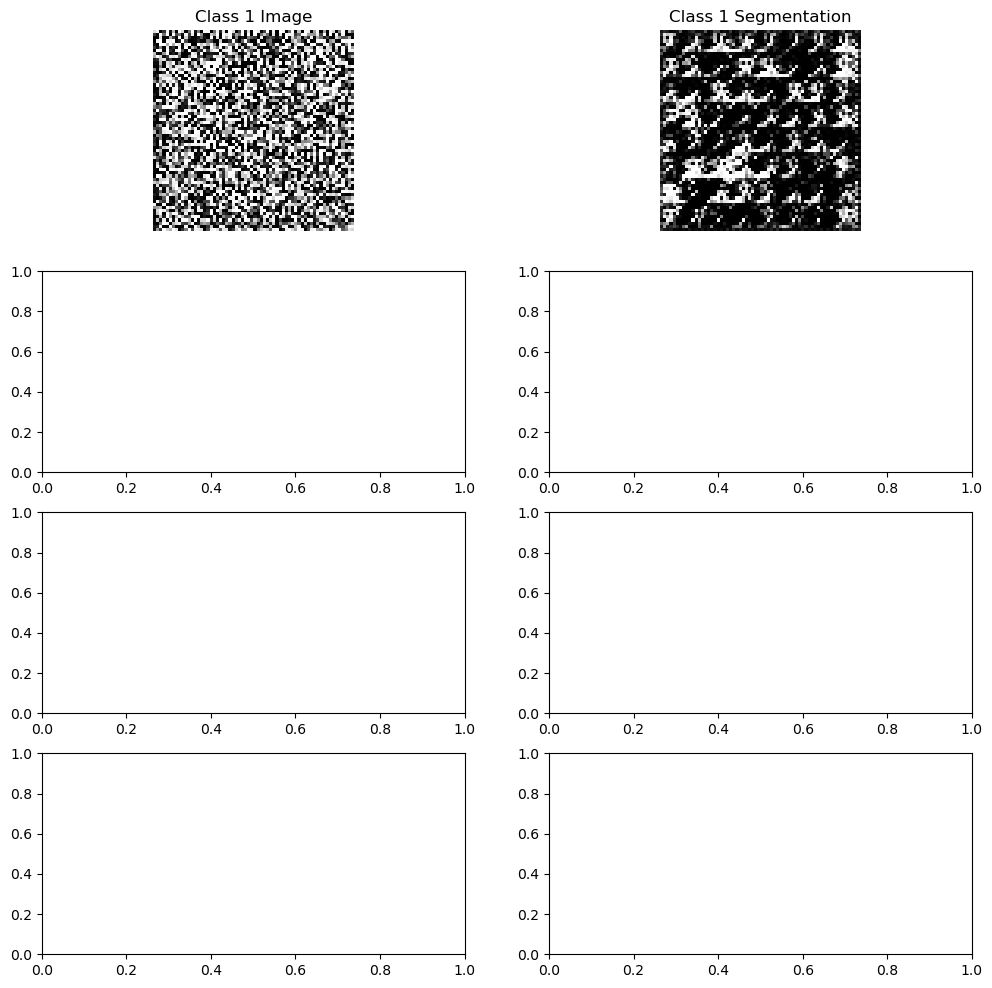

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image

# Define the generator
class Generator(nn.Module):
    def __init__(self, noise_dim, num_classes):
        super(Generator, self).__init__()
        
        # Define the noise and class input dimensions
        input_dim = noise_dim + num_classes
        
        # Generator architecture
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 1024 * 8 * 8),
            nn.ReLU(True)
        )
        
        # Transposed convolution layers to generate image and segmentation
        self.image_gen = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1),
            nn.Tanh()  # Image output range: [-1, 1]
        )
        
        self.seg_gen = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1),
            nn.Sigmoid()  # Segmentation output range: [0, 1]
        )
    
    def forward(self, noise, labels):
        # Concatenate noise and one-hot encoded labels
        x = torch.cat((noise, labels), dim=1)
        
        # Pass through the fully connected layer
        x = self.fc(x)
        x = x.view(-1, 1024, 8, 8)
        
        # Generate image and segmentation map separately
        image = self.image_gen(x)
        seg = self.seg_gen(x)
        
        return image, seg




class Discriminator(nn.Module):
    def __init__(self, device='cuda'):
        super(Discriminator, self).__init__()

        # Define device
        self.device = torch.device(device)
        
        # Network architecture for discriminator
        self.main = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=4, stride=2, padding=1),  # Concatenated input (image + seg)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten()  # Flatten the output to feed into fully connected layer
        ).to(self.device)  # Move the main sequential module to the device

        # Initialize to None for lazy initialization later
        self.fc = None
        self.output_layer = None
        
    def forward(self, image, seg):
        # Move inputs to the specified device
        image = image.to(self.device)
        seg = seg.to(self.device)
        

        
        # Concatenate image and segmentation map
        x = torch.cat((image, seg), dim=1)  # Concatenate on the channel dimension
        
        # Pass through the network
        x = self.main(x)
        
        # Lazy initialization of fully connected layer and output layer
        if self.fc is None:
            # Initialize the fully connected layer with the correct input size
            input_size = x.shape[1]  # Get the number of features in the flattened output
            self.fc = nn.Linear(input_size, 1).to(self.device)  # Move to the specified device
            self.output_layer = nn.Sigmoid().to(self.device)  # Move to the specified device
            self.add_module('fc', self.fc)
            self.add_module('output_layer', self.output_layer)
        
        # Pass through the fully connected and output layers
        x = self.fc(x)
        output = self.output_layer(x)
        
        return output




# Custom dataset class
class SegmentationDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        
        # Initialize list of image, segmentation, and labels
        self.image_files = []
        self.seg_files = []
        self.labels = []
        
        # Define label mapping
        self.label_mapping = {
            'glioma': 0,
            'healthy': 1,
            'pituitary': 2,
            'meningioma': 3
        }
        
        # Collect file paths and labels
        for class_name in self.label_mapping:
            class_folder = os.path.join(data_folder, class_name)
            for filename in os.listdir(class_folder):
                if filename.endswith('.jpg'):
                    # Get the corresponding segmentation file
                    seg_filename = filename.replace('.jpg', '_mask.png')
                    img_path = os.path.join(class_folder, filename)
                    seg_path = os.path.join(class_folder, seg_filename)
                    
                    # Check if segmentation file exists
                    if os.path.exists(seg_path):
                        self.image_files.append(img_path)
                        self.seg_files.append(seg_path)
                        self.labels.append(self.label_mapping[class_name])
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, index):
        # Load image, segmentation, and label
        img_path = self.image_files[index]
        seg_path = self.seg_files[index]
        label = self.labels[index]
        
        # Load image and segmentation map
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        seg = Image.open(seg_path).convert('L')  # Convert to grayscale
        
        # Apply transforms
        if self.transform:
            img = self.transform(img)
            seg = self.transform(seg)
        
        # One-hot encode the label
        label_one_hot = torch.zeros(4)
        label_one_hot[label] = 1
        
        return img, seg, label_one_hot

# Hyperparameters
noise_dim = 100
num_classes = 4  # Number of different classes
output_channels = 1  # Grayscale images

# Define the device for computation (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Instantiate the generator and discriminator
generator = Generator(noise_dim, num_classes).to(device)
discriminator = Discriminator().to(device)

# Optimizers
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Load the dataset and create data loader
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Set the path to your data folder
data_folder = "./tumor_dataset"
dataset = SegmentationDataset(data_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

import matplotlib.pyplot as plt
import numpy as np

# Function to visualize four sample generated images for each class
def visualize_fake_images_and_segs(fake_images, fake_segs, labels, epoch, step):
    # Convert the generated images and segmentations to numpy arrays and denormalize
    fake_images_np = (fake_images.detach().cpu().numpy() * 0.5 + 0.5).squeeze(1)  # Denormalize and squeeze channels
    fake_segs_np = fake_segs.detach().cpu().numpy().squeeze(1)  # Convert segmentation to numpy and squeeze channels
    labels_np = labels.detach().cpu().numpy()  # Convert labels to numpy arrays

    # Define the number of classes
    num_classes = labels_np.shape[1]

    # Create a figure with a grid layout (4 rows for each class, 2 columns for image and segmentation)
    fig, axes = plt.subplots(num_classes, 2, figsize=(12, 12))
    
    # Iterate through each class
    for class_idx in range(num_classes):
        # Find the indices of images with the current class label
        class_indices = np.where(labels_np[:, class_idx] == 1)[0]
        
        # Sample one image and segmentation for the current class
        sampled_idx = np.random.choice(class_indices)
        
        # Plot the image
        axes[class_idx, 0].imshow(fake_images_np[sampled_idx], cmap='gray')
        axes[class_idx, 0].set_title(f"Class {class_idx + 1} Image")
        axes[class_idx, 0].axis('off')
        
        # Plot the segmentation
        axes[class_idx, 1].imshow(fake_segs_np[sampled_idx], cmap='gray')
        axes[class_idx, 1].set_title(f"Class {class_idx + 1} Segmentation")
        axes[class_idx, 1].axis('off')
    
    # Set the overall title for the figure
    plt.suptitle(f"Epoch {epoch + 1}, Step {step}")
    plt.show()

# Training the GAN
num_epochs = 50000
visualize_interval = 1000  # Adjust interval as needed

for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    
    for step, (images, segs, labels) in enumerate(dataloader):
        # Move data to the device
        images = images.to(device)
        segs = segs.to(device)
        labels = labels.to(device)
        
        # Generate noise
        noise = torch.randn(images.size(0), noise_dim, device=device)
        
        # Generate fake images and segmentations
        fake_images, fake_segs = generator(noise, labels)
        
        # Train discriminator
        d_optimizer.zero_grad()
        
        # Real data labels
        real_labels = torch.ones(images.size(0), device=device)
        fake_labels = torch.zeros(images.size(0), device=device)
        
        # Real data output
        real_output = discriminator(images, segs)
        d_loss_real = criterion(real_output.squeeze(), real_labels)
        
        # Fake data output
        fake_output = discriminator(fake_images, fake_segs)
        d_loss_fake = criterion(fake_output.squeeze(), fake_labels)
        
        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward(retain_graph=True)
        d_optimizer.step()
        
        # Train generator
        g_optimizer.zero_grad()
        
        # Pass the generated fake data through the discriminator again
        fake_output = discriminator(fake_images, fake_segs)
        
        # Generator loss
        g_loss = criterion(fake_output.squeeze(), real_labels)
        
        g_loss.backward(retain_graph=True)
        g_optimizer.step()
        
        # Print losses occasionally
        if epoch % 100 == 0 and step==0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{step}/{len(dataloader)}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
        
        # Visualize four sample generated images for each class at the specified interval
        if (epoch % visualize_interval==0 or epoch ==0)  and step == 0:
            visualize_fake_images_and_segs(fake_images, fake_segs, labels, epoch, step)
    
    # Save the model checkpoints if necessary
    # torch.save(generator.state_dict(), "generator.pth")
    # torch.save(discriminator.state_dict(), "discriminator.pth")